<a href="https://colab.research.google.com/github/NataliaCondori/Sign-language-detection-based-on-fingers-and-face-trajectory/blob/main/MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    confusion_matrix,
    roc_auc_score,
    recall_score,
    f1_score,
)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the main folder path to the dataset of images
principal_folder = r"/content/drive/MyDrive/VISION ARTIFICIAL/Dataset_imagenes_v2/"
!ls "{principal_folder}"

'01 Gracias'	     '05 Papa'	   '09 Abuelo'	 '13 Esposo'	'17 Puente'
'02 Muchas_gracias'  '06 Mama'	   '10 Tio'	 '14 Primo'	'18 Calle'
'03 Bienvenidos'     '07 Hermano'  '11 Sobrino'  '15 Casa'	'19 Avenida'
'04 Lo_espero'	     '08 Hijo'	   '12 Esposa'	 '16 Hospital'	'20 Plaza'


In [ ]:
# Create a list of image folders within the principal folder
image_folders = [
    os.path.join(principal_folder, d)
    for d in os.listdir(principal_folder)
    if os.path.isdir(os.path.join(principal_folder, d))
]
image_folders.sort()

In [ ]:
# Create a list of image files for each folder
image_files = []
for folder in image_folders:
    images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
    image_files.append(images)

In [ ]:
# Create lists to store the image paths and labels
images, labels = [], []
for index, folder in enumerate(image_files):
    for image in folder:
        images.append(image)
        labels.append(index)

In [ ]:
# Shuffle the images and labels to maintain correspondence
indices = np.arange(len(images))
np.random.shuffle(indices)
images = [images[i] for i in indices]
labels = [labels[i] for i in indices]

In [ ]:
# Split the images and labels into training, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.16, random_state=42
)
validation_images, test_images, validation_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42
)

In [ ]:
# Load and preprocess an image given its path.
def load_and_preprocess_image(path):
    # Read the image file
    image = tf.io.read_file(path)
    # Decode the image and convert it to float32 data type
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    # Normalize the image by dividing it by 255
    image /= 255.0
    return image.numpy().astype(np.float32)

In [ ]:
# Generate ordered batches of images and labels.
def ordered_image_generator(image_files, labels, batch_size):
    num_samples = len(image_files)
    while True:
        for offset in range(0, num_samples, batch_size):
            # Get the batch of image files and labels for the current offset
            batch_files = image_files[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            batch_images = []
            for file in batch_files:
                # Load and preprocess each image in the batch
                image = load_and_preprocess_image(file)
                batch_images.append(image)
            yield np.array(batch_images), np.array(batch_labels)

In [ ]:
# Model architecture definition
model = tf.keras.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(480, 720, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.35),
    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(20, activation='softmax')
])

In [ ]:
# Model compilation
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

##TRAIN

In [ ]:
# Batch size for training
batch_size = 32

# Create generators for training and validation sets
train_generator = ordered_image_generator(train_images, train_labels, batch_size)
validation_generator = ordered_image_generator(validation_images, validation_labels, batch_size)

# Calculate steps per epoch based on training set size and batch size
steps_per_epoch = len(train_images) // batch_size

# Train the model for 5 epochs using the generators
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=5)

Epoch 1/5
83/83 [==============================] - 2376s 28s/step - loss: 2.9737 - accuracy: 0.1333
Epoch 2/5
83/83 [==============================] - 2335s 28s/step - loss: 1.7438 - accuracy: 0.4541
Epoch 3/5
83/83 [==============================] - 2332s 28s/step - loss: 0.6997 - accuracy: 0.7637
Epoch 4/5
83/83 [==============================] - 2331s 28s/step - loss: 0.4405 - accuracy: 0.8567
Epoch 5/5
83/83 [==============================] - 2339s 28s/step - loss: 0.3279 - accuracy: 0.8919


## Validation

In [ ]:
# Calculate validation steps based on validation set size and batch size
validation_steps = len(validation_images) // batch_size

# Evaluate the model using the validation generator
predictions = model.evaluate(validation_generator, steps=validation_steps)

7/7 [==============================] - 54s 7s/step - loss: 0.4266 - accuracy: 0.8795


##TESTING

In [ ]:
processed_images = []
for image_path in test_images:
    # Load and preprocess each test image
    image = load_and_preprocess_image(image_path)
    processed_images.append(image)
input_images = np.array(processed_images)

In [ ]:
# Perform prediction on the preprocessed test images
prediction = model.predict(input_images)
# Get the predicted labels by finding the index of the maximum probability in each prediction
predicted_labels = np.argmax(prediction, axis=1)
# Calculate the accuracy by comparing the predicted labels with the actual labels
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"The accuracy of the model is {accuracy*100:.2f}%")

8/8 [==============================] - 58s 7s/step
La precisión del modelo es 90.59%


In [ ]:
# Define the list of elements corresponding to the classes of the classification problem
elements = ['gracias', 'muchas gracias', 'bienvenidos', 'lo espero', 'papa', 'mama', 'hermano', 'hijo', 'abuelo',
            'tio', 'sobrino', 'esposa', 'esposo', 'primo', 'casa', 'hospital', 'puente', 'calle', 'avenida', 'plaza']

In [ ]:
principal_folder = r"/content/drive/MyDrive/VISION ARTIFICIAL/Dataset_imagenes_v2/"
!ls "{principal_folder}"

'01 Gracias'	     '05 Papa'	   '09 Abuelo'	 '13 Esposo'	'17 Puente'
'02 Muchas_gracias'  '06 Mama'	   '10 Tio'	 '14 Primo'	'18 Calle'
'03 Bienvenidos'     '07 Hermano'  '11 Sobrino'  '15 Casa'	'19 Avenida'
'04 Lo_espero'	     '08 Hijo'	   '12 Esposa'	 '16 Hospital'	'20 Plaza'


In [ ]:
# Find the index of the label '5' in the test labels list
test_labels.index(5)

6

In [ ]:
# Save the model to an HDF5 file at the specified location
model.save("/content/drive/MyDrive/modelo_v2_1.h5")

mama


<ipython-input-57-e071631769f7>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(elements, rotation='vertical')


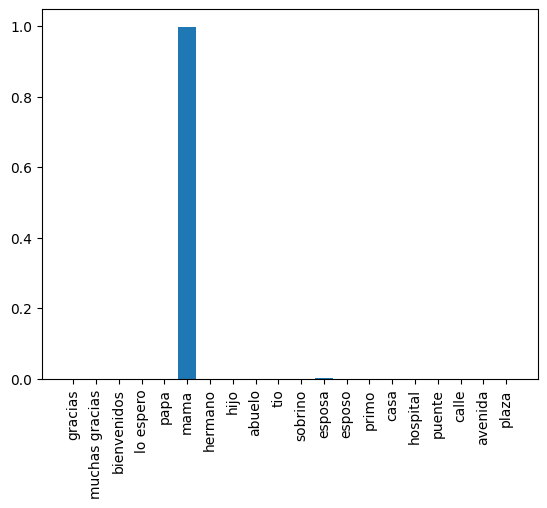

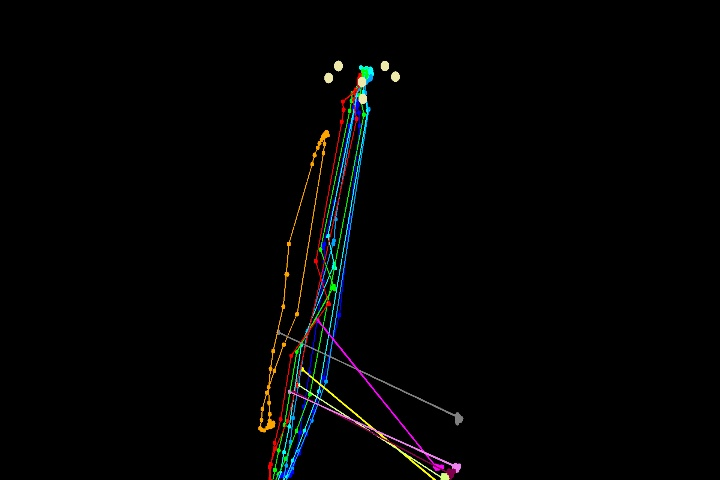

In [ ]:
x = 6
print(elements[int(test_labels[x])])

# Create a bar chart with predicted class probabilities for the example at index x
fig, ax = plt.subplots()
ax.bar(elements, prediction[x])
ax.set_xticklabels(elements, rotation='vertical')
plt.show()

# Display the corresponding image
cv2_imshow(cv2.imread(test_images[x]))

papa


<ipython-input-55-c7679903c638>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(elements, rotation='vertical')


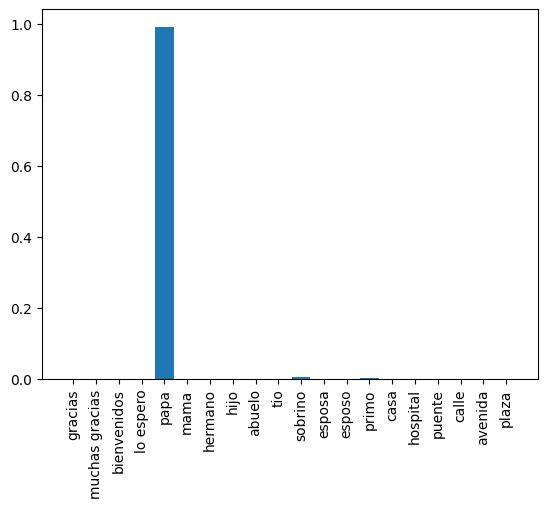

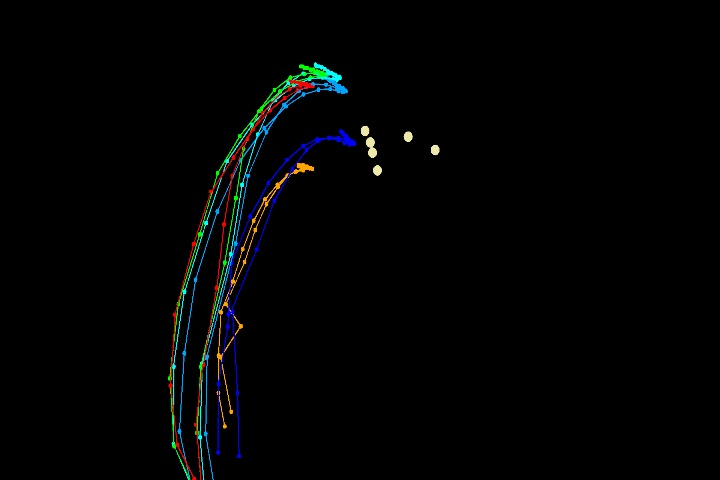

In [ ]:
x = 7
print(elements[int(test_labels[x])])

# Create a bar chart with predicted class probabilities for the example at index x
fig, ax = plt.subplots()
ax.bar(elements, prediction[x])
ax.set_xticklabels(elements, rotation='vertical')
plt.show()

# Display the corresponding image
cv2_imshow(cv2.imread(test_images[x]))

tio


<ipython-input-49-1353f8f8b50d>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(elements, rotation='vertical')


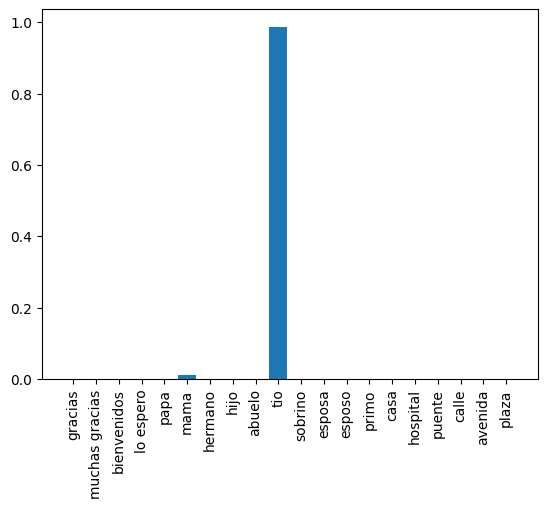

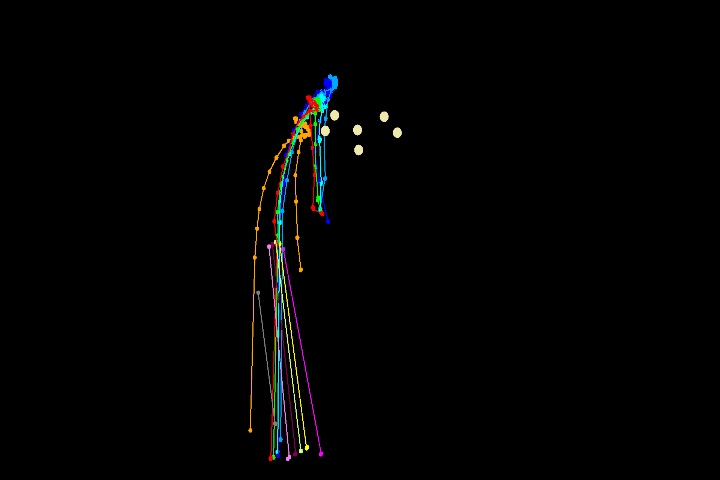

In [ ]:
x = 41
print(elements[int(test_labels[x])])

# Create a bar chart with predicted class probabilities for the example at index x
fig, ax = plt.subplots()
ax.bar(elements, prediction[x])
ax.set_xticklabels(elements, rotation='vertical')
plt.show()

# Display the corresponding image
cv2_imshow(cv2.imread(test_images[x]))

sobrino


<ipython-input-52-b31ce1f0acdd>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(elements, rotation='vertical')


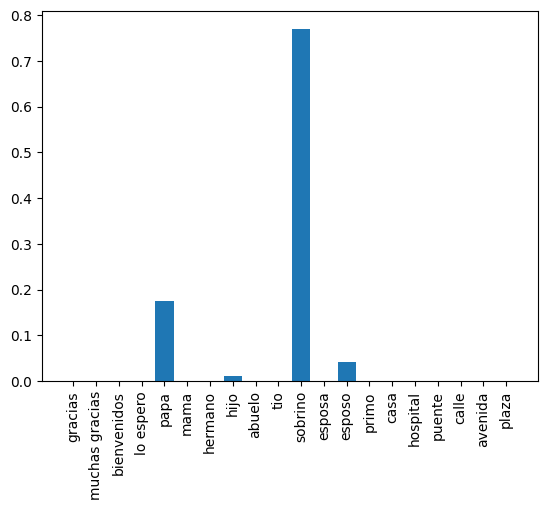

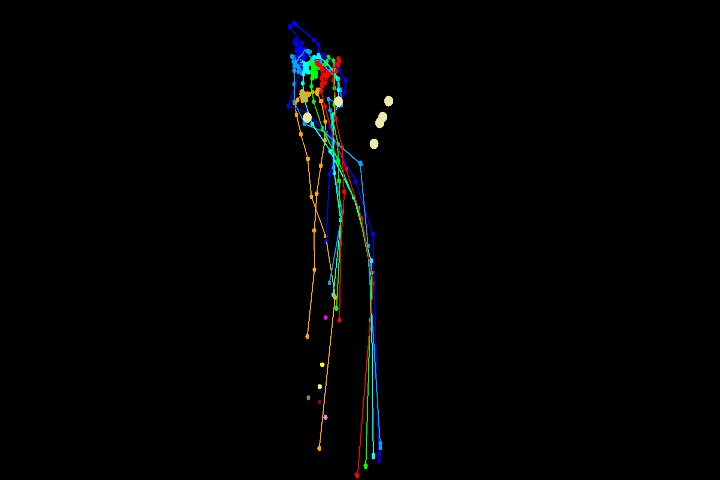

In [ ]:
x = 5
print(elements[int(test_labels[x])])

# Create a bar chart with predicted class probabilities for the example at index x
fig, ax = plt.subplots()
ax.bar(elements, prediction[x])
ax.set_xticklabels(elements, rotation='vertical')
plt.show()

# Display the corresponding image
cv2_imshow(cv2.imread(test_images[x]))

calle


<ipython-input-46-94bbb79787fa>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(elements, rotation='vertical')


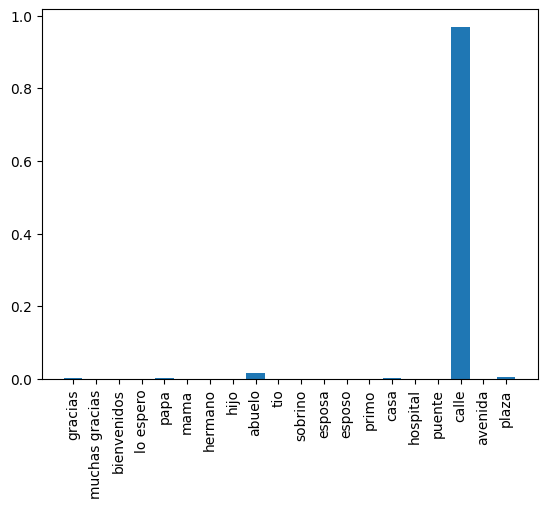

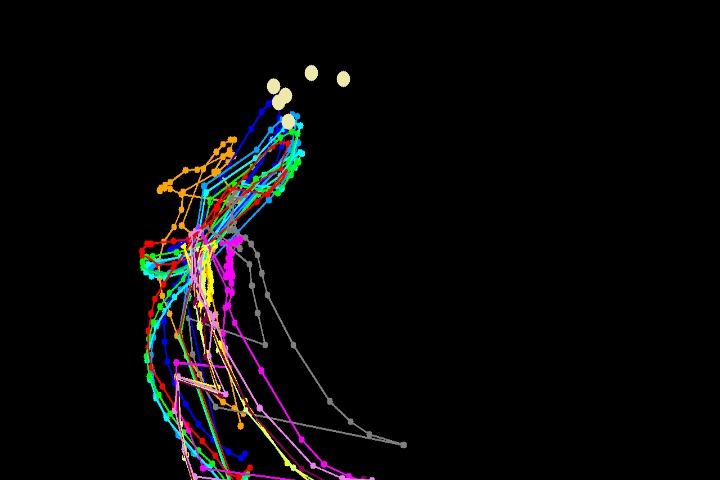

In [ ]:
x = 29
print(elements[int(test_labels[x])])

# Create a bar chart with predicted class probabilities for the example at index x
fig, ax = plt.subplots()
ax.bar(elements, prediction[x])
ax.set_xticklabels(elements, rotation='vertical')
plt.show()

# Display the corresponding image
cv2_imshow(cv2.imread(test_images[x]))